<h1 class="heading">Wind Reconstructor</h1>
<h1>Actuator Line Model - Case (1,2) - Deterministic trajectories</h1>

<h6 class="author"> — <b style="color:rgb(0,51,102);">Carmine Varriale, Agostino De Marco</b>, <i>University of Naples Federico II</i></h6>

## Introduction
In this notebook, we are going to simulate the flight of our aircraft through the middle of the wake of a wind turbine.
The aircraft is a modified version of the Cessna 172 Skyhawk: it has been scaled down from a geometric and inertial point of view, in order to be closer to an Ikarus C42, for which some theoretical results are available from a previous study. The aerodynamic model has not been changed at all, considering that the two aircraft have comparable configurations overall.
<br><br>
The turbine is represented by an actuator line model, and the inflow by a uniform velocity field.

In [1]:
% run ./python/nb_init.py
% matplotlib inline

import numpy as np
import utm

import geography as geo
import data_handling as dh
from property_map import pmap
from MCSim import *

## Case specific settings
Wind speed at the actuator disk is $12\ \mathrm{m/s}$. <br>
Wind direction is $270°$ ccw with respect to local north and turbine is facing the west direction, i.e. the turbine is working with perfectly axial wind.
<br>
<img src="./images/ALM12wakeFromAbove300.png" />
<img src="./images/ALM12wakeFromAboveUz300.png" />

In [2]:
# Turbine diameter
D_t = 126 #m

# Assign turbine Lat-Lon coordinates and height
Lat_t = 53.153588 #deg
Lon_t = 8.162655  #deg
H_t   = 90      #m

# Calculate turbine UTM coordinates
X_t, Y_t, zone_num, zone_lett = utm.from_latlon(Lat_t, Lon_t)
print("X_t =  {0:.14f} m (Easting coord.)".format(X_t), sep="")
print("Y_t =  {0:.14f} m (Northing coord.)".format(Y_t), sep="")

X_t =  444005.64156725001521 m (Easting coord.)
Y_t =  5889683.58956928178668 m (Northing coord.)


<div class="main">
At this point, we can <b>manually</b> translate the whole mesh in order to give the turbine the above coordinates in UTM reference frame. By default, the simulation has been run with turbine base position being $(0.0, 0.0, -90.0)\ \mathrm{m}$ and tower height being $90.0\ \mathrm{m}$, so the center of the disk is supposed to be at $z_t = 0.0\ \mathrm{m}$.
<br><br>
The command to run in the OpenFoam case directory in order to translate the mesh is derived as follows

In [3]:
x_t = 0.0; y_t = 0.0; z_t = 0.0;

delta_X = X_t - x_t
delta_Y = Y_t - y_t
delta_Z = H_t - z_t

print('transformPoints -translate "(',delta_X,' ',delta_Y,' ',delta_Z,')"', ' >& log.transformPoints &', sep='')

transformPoints -translate "(444005.64156725 5889683.589569282 90.0)" >& log.transformPoints &


For a quick check on mesh quality, it might be worth to also execute
<div class="path">checkMesh >& log.checkMesh &</div>
</div>

In [4]:
# List of distances from the disk, in terms of turbine diameters
# The length of the list is equal to the number of simulations for each speed value
nD_t = [0,1,2,3,4,5,6,7,8,9]

# Calculate aircraft initial positions, relative to turbine, in UTM
X0 = list(X_t + np.asarray(nD_t)*D_t)
Y0 = Y_t - 1500

At this point, we have the full set of initial and corresponding final positions of the aircraft. Our goal is to create a simulation family for each of this couples: within the family, initial speed will be fixed while initial position with respect to the turbine will vary, thanks to the already well known <span class="typewr">generate_series</span> function. Finally, the aircraft initial speed and altitude will also be iterated in the set, through a simple external <span class="typewr">for</span> loop.

## Simulation control panel

In [5]:
vV =      [50,    100]      #kts
vh =      [H_t+26.6, H_t+23.5]  #m
vDeltaX = [-78.8, +22.8]        #m   (initial position corrections for first fly-through at 1 diameter)

for i in range(len(vV)):
    script     = 'c172mod_OF_ALM'
    autopilot  = 'c172ap_unina_mod'
    output_fol = 'c172mod_OF_ALM12_V'+str(vV[i])

    # Creating instance of the class
    ALM12 = WRSimFamily(len(nD_t), 
                        seed_name      = script,
                        autopilot_name = autopilot,
                        out_foldername = output_fol,
                        port_num=1025)
    
    # Correct initial position on the basis of initial speed
    X0corr = [x0 + vDeltaX[i] for x0 in X0]

    # Calculate waypoints positions in UTM
    X1 = X0corr ; Y1 = Y_t + 1500

    # Convert such positions to Lat-Lon coordinates
    def LatLon_from_utm(X, Y, zone_num, zone_lett):
        LatLon = [utm.to_latlon(X[i], Y, zone_num, zone_lett) for i in range(len(nD_t))]
        Lat = [LatLon[i][0] for i in range(len(X))] #deg
        Lon = [LatLon[i][1] for i in range(len(X))] #deg
        return Lat, Lon

    Lat0, Lon0 = LatLon_from_utm(X0corr, Y0, zone_num, zone_lett)
    Lat1, Lon1 = LatLon_from_utm(X1, Y1, zone_num, zone_lett)
    
    
    # Initial positions
    ALM12.generate_series('latitude', 'from_list', Lat0)
    ALM12.generate_series('longitude', 'from_list', Lon0)

    # Waypoint positions
    ALM12.generate_series('guidance/target-wp-latitude-rad-final',  'from_list', np.radians(Lat1))
    ALM12.generate_series('guidance/target-wp-longitude-rad-final', 'from_list', np.radians(Lon1))

    # Flight parameters
    h_m       = ALM12.set_value('altitude', vh[i])
    psi_deg   = ALM12.set_value('psi', 0)
    gamma_deg = ALM12.set_value('gamma', -1)
    V_kts     = ALM12.set_value('vt', vV[i])
    
    # Launch family of simulations
    #ALM12.launch_mc_sim(log='off', system='linux')

In [55]:
Gr50 = PostGroup('c172mod_OF_ALM12_V'+str(vV[0]), 'c172x_unina_mod', list(range(1,20+1)),'50')
#Gr50.get_traj_in_UTM()
Gr50.load_traj_in_UTM()

Gr50A = PostGroup('c172mod_OF_ALM12_V'+str(vV[0]), 'c172x_unina_mod', list(range(1,6)),'50A')
#Gr50A.get_traj_in_UTM()
Gr50A.load_traj_in_UTM()

Gr50B = PostGroup('c172mod_OF_ALM12_V'+str(vV[0]), 'c172x_unina_mod', list(range(16,20+1)),'50B')
Gr50B.get_traj_in_UTM()
#Gr50B.load_traj_in_UTM()

Gr100 = PostGroup('c172mod_OF_ALM12_V'+str(vV[1]), 'c172x_unina_mod', list(range(1,20+1)),'100')
#Gr100.get_traj_in_UTM()
Gr100.load_traj_in_UTM()

Gr100A = PostGroup('c172mod_OF_ALM12_V'+str(vV[1]), 'c172x_unina_mod', list(range(1,6)),'100A')
#Gr100A.get_traj_in_UTM()
Gr100A.load_traj_in_UTM()

Gr100B = PostGroup('c172mod_OF_ALM12_V'+str(vV[1]), 'c172x_unina_mod', list(range(16,20+1)),'100B')
Gr100B.get_traj_in_UTM()
#Gr100B.load_traj_in_UTM()

Total time required: 65.52 s
Total time required: 15.70 s
Total time required: 14.96 s
Total time required: 28.28 s
Total time required: 6.58 s
Total time required: 5.69 s


## Trajectory

Total time required: 2.46 s
Total time required: 1.47 s


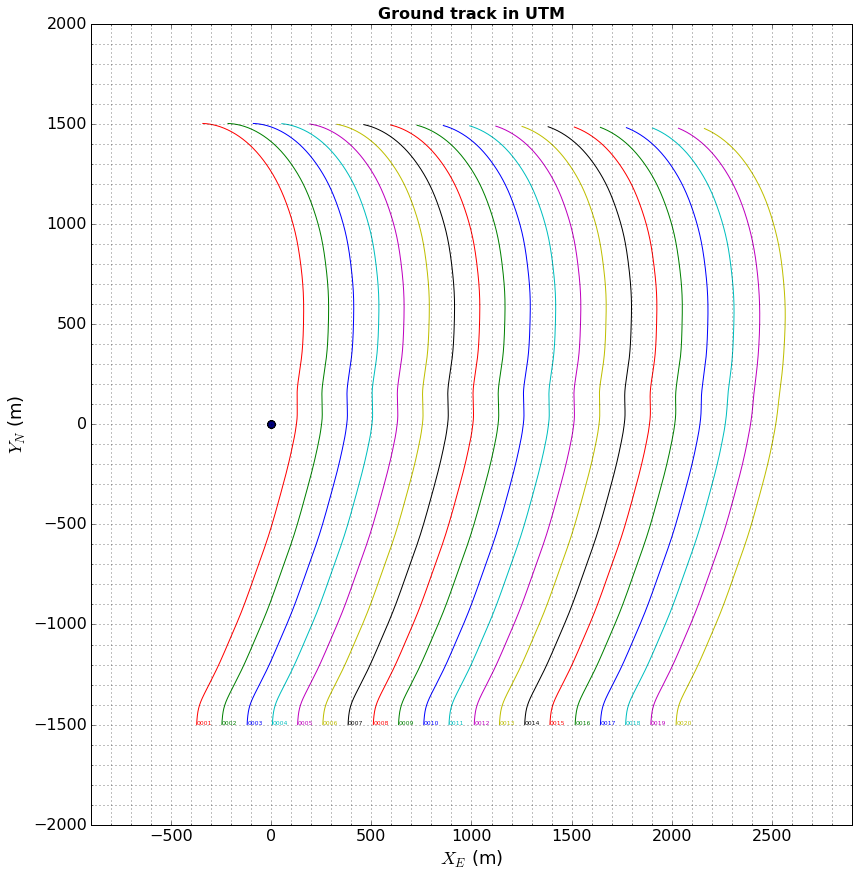

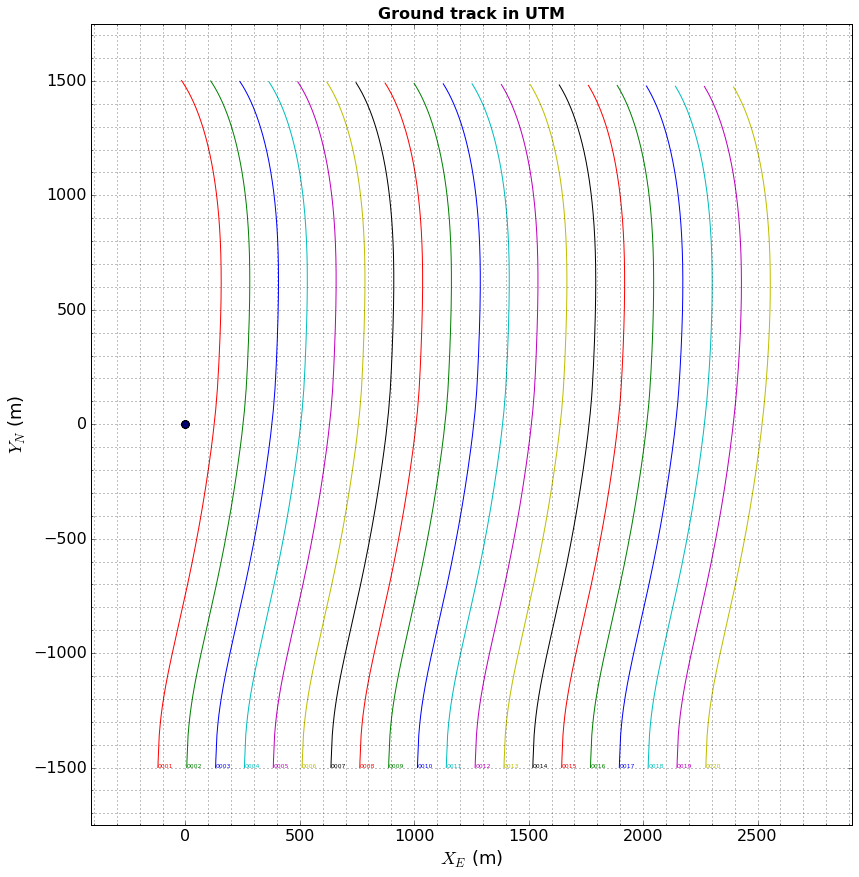

In [9]:
Gr50.plot_ground_track_UTM(origin=[X_t, Y_t], ax_lim=[None, None, -1510, +1510], lbl_idx=0)
Gr100.plot_ground_track_UTM(origin=[X_t, Y_t], ax_lim=[None, None, -1510, +1510], lbl_idx=0)

Total time required: 1.23 s
Total time required: 1.92 s


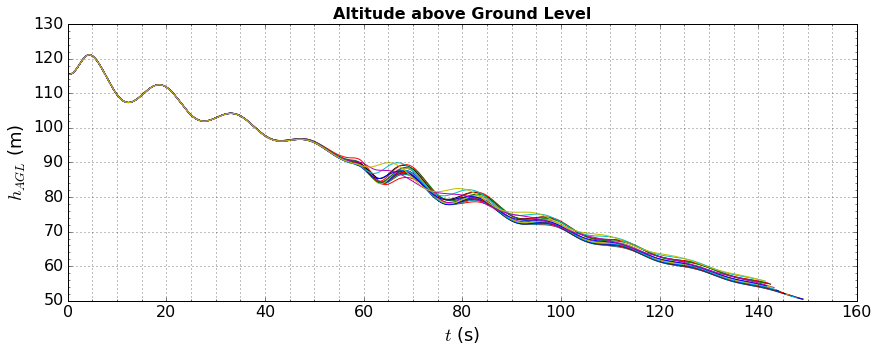

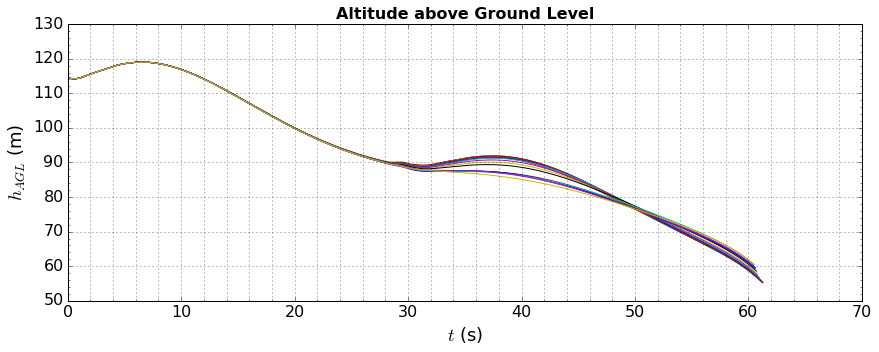

In [11]:
Gr50.plot_vars('h_agl_m', ax_lim=[None,None,50,130])
Gr100.plot_vars('h_agl_m', ax_lim=[None,None,50,130])

Total time required: 1.62 s
Total time required: 2.19 s


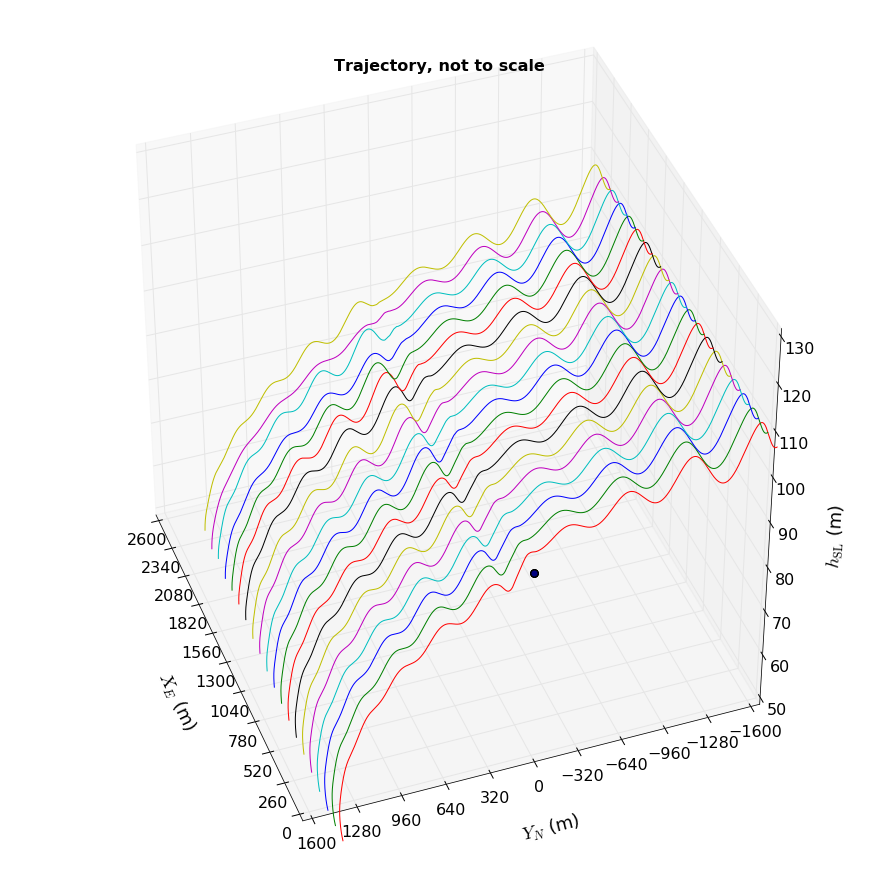

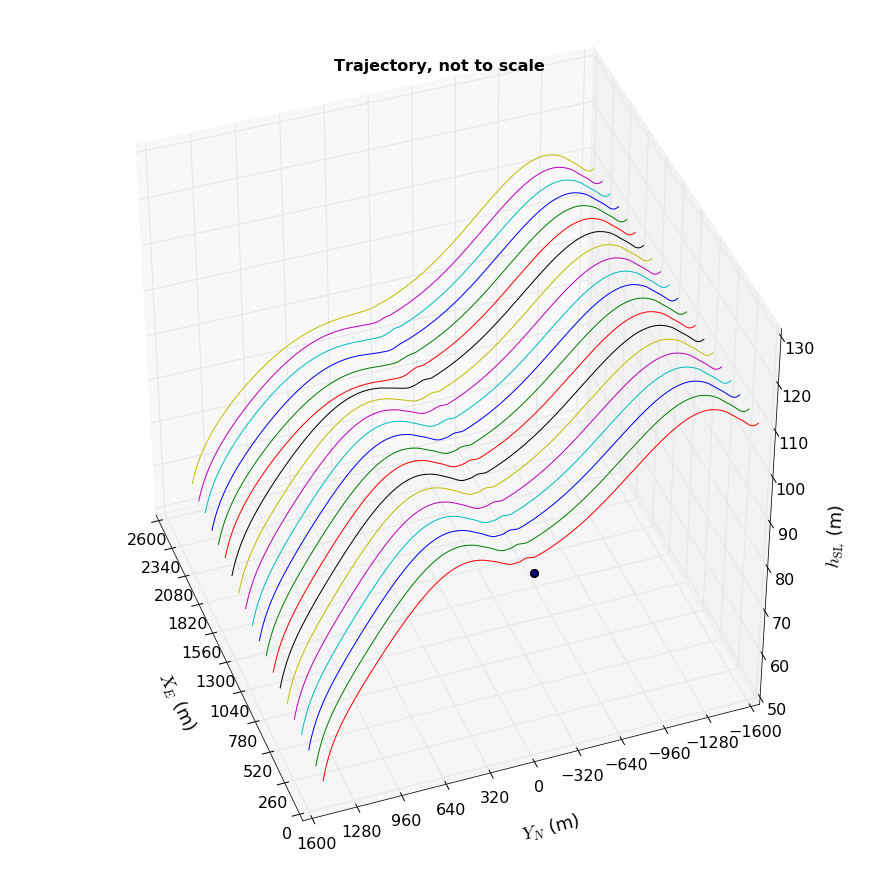

In [13]:
Gr50.plot_traj3D_UTM(origin=[X_t, Y_t], Hdisk=H_t, to_scale='XY', ax_lim=[0,2600,-1600,1600,50,130], \
                    nticks=[11,11,9], view=(40,160), legend='off')
Gr100.plot_traj3D_UTM(origin=[X_t, Y_t], Hdisk=H_t, to_scale='XY', ax_lim=[0,2600,-1600,1600,50,130], \
                    nticks=[11,11,9], view=(40,160), legend='off')

## Wind speed in UTM reference frame
We look at the Eastern component to understand when the aircraft actually enters the wake for the wind deficit makes it as clear as possible. We therefore use this time history as a visual reference for our further observations.

Total time required: 1.11 s
Total time required: 1.15 s


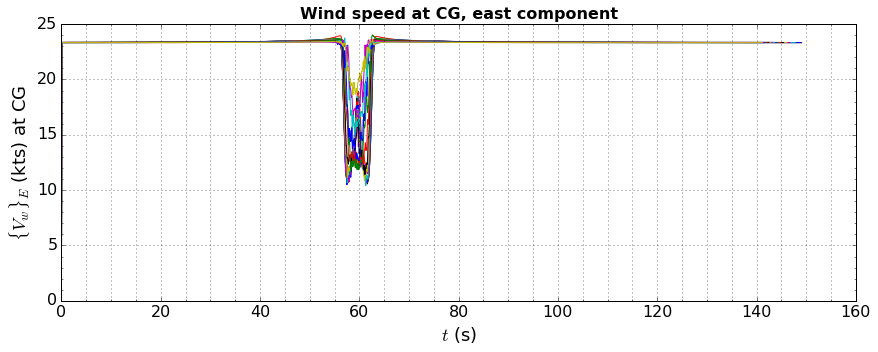

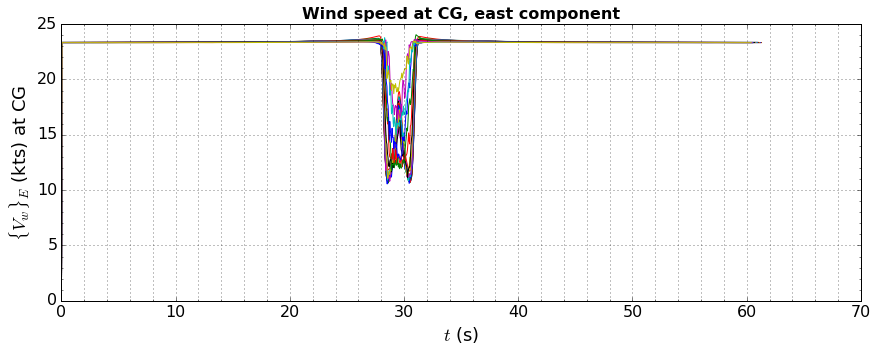

In [14]:
Gr50.plot_vars('Vw_E_kts')
Gr100.plot_vars('Vw_E_kts')

In [15]:
# Wake crossing time flags
t1_50 = 50; t2_50 = 70
t1_100 = 24; t2_100 = 34

## Attitude

Total time required: 1.79 s
Total time required: 1.07 s


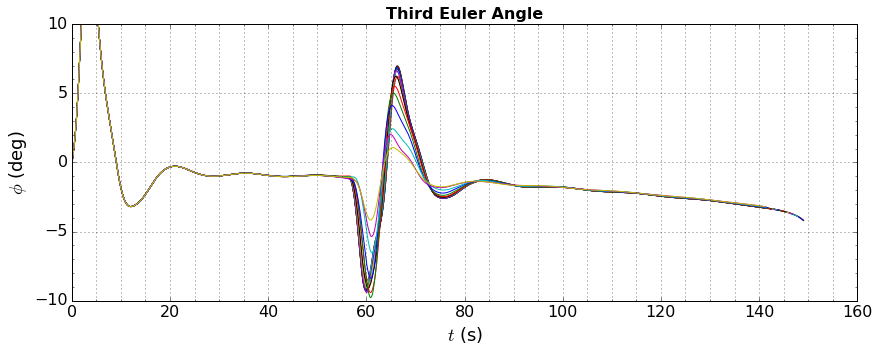

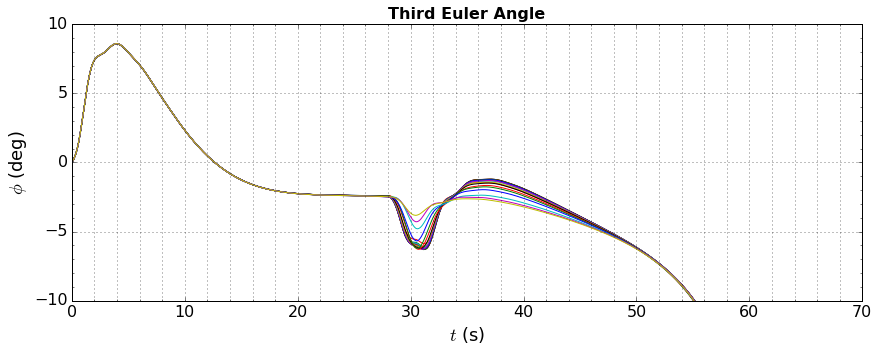

In [17]:
Gr50.plot_vars('phi_deg', ax_lim=[None,None,-10,10])
Gr100.plot_vars('phi_deg',ax_lim=[None,None,-10,10])

Total time required: 1.12 s
Total time required: 1.06 s


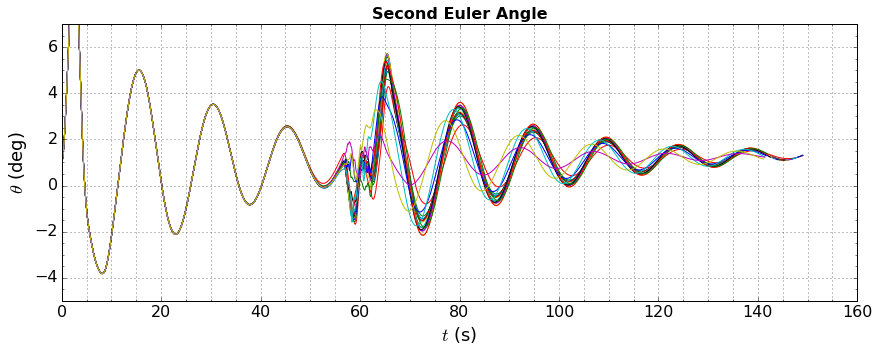

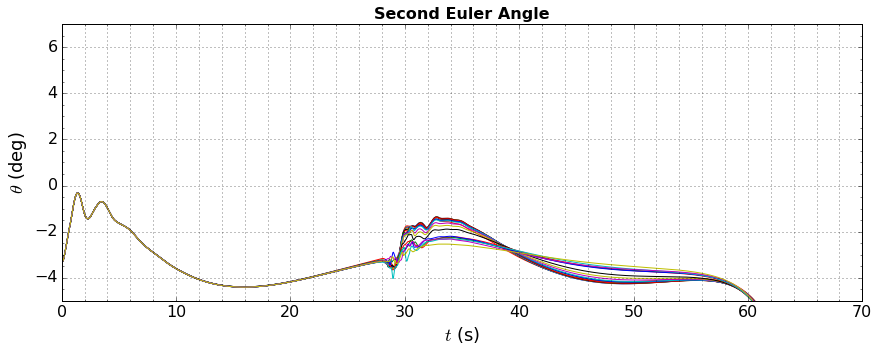

In [19]:
Gr50.plot_vars('theta_deg', ax_lim=[None,None,-5,7])
Gr100.plot_vars('theta_deg', ax_lim=[None,None,-5,7])

## Flight control system

Total time required: 1.14 s
Total time required: 1.78 s


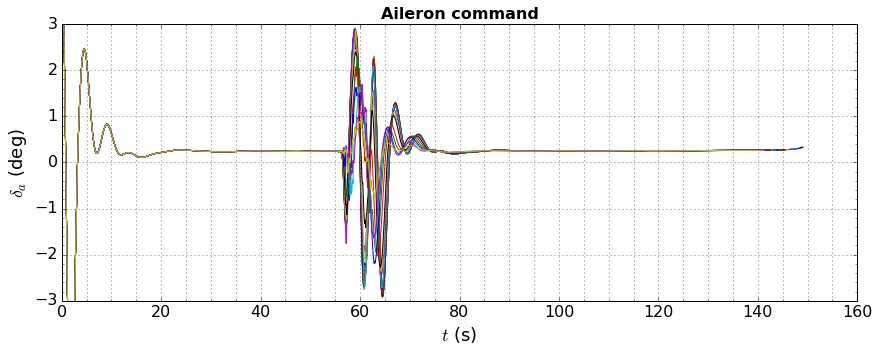

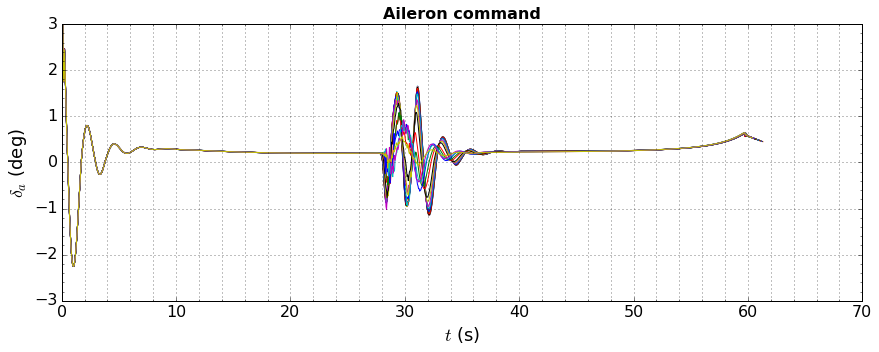

In [20]:
Gr50.plot_vars('delta_a', ax_lim=[None,None,-3,3])
Gr100.plot_vars('delta_a', ax_lim=[None,None,-3,3])

Total time required: 1.98 s
Total time required: 1.29 s


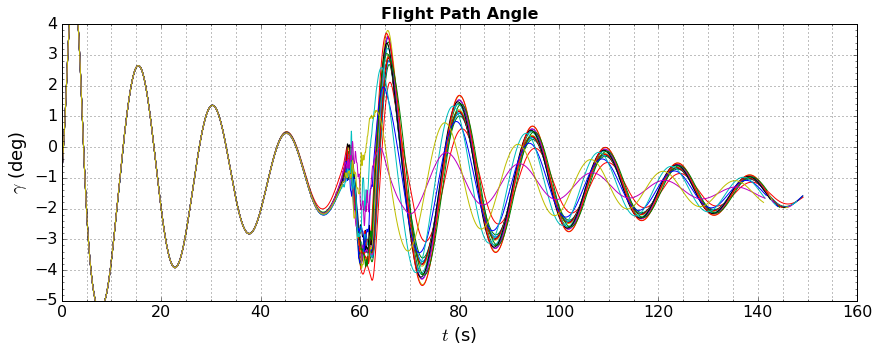

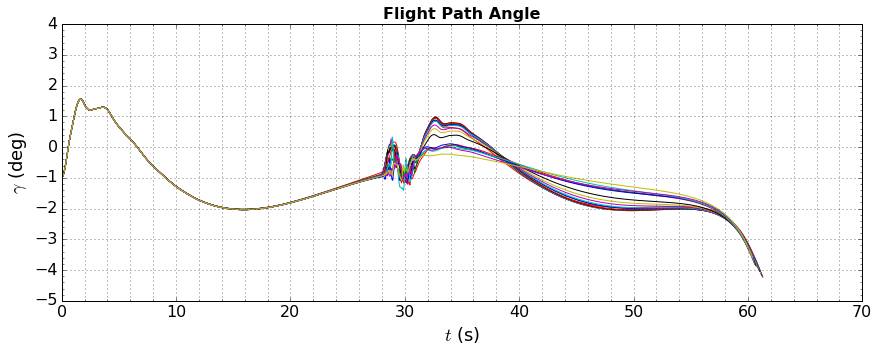

In [22]:
Gr50.plot_vars('gamma_deg', ax_lim=[None,None,-5,4])
Gr100.plot_vars('gamma_deg', ax_lim=[None,None,-5,4])

## Wind speed in body reference frame

For these parameters we are using the <span class="typewr">plot_results</span> function, which plots data from the <span class="typewr">finalresults.csv</span> file, where it was output by JSBSim at a frequency of 120 Hz, a much higher resolution compared to the normal 20 Hz of all the other output files. It is also equal to the interpolation frequency, which means that we are plottig exactly what the pilot felt during the crossing of the wake.

Total time required: 13.34 s
Total time required: 13.61 s


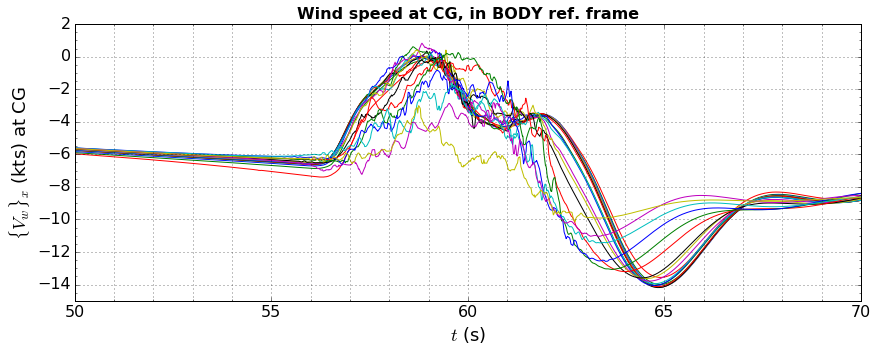

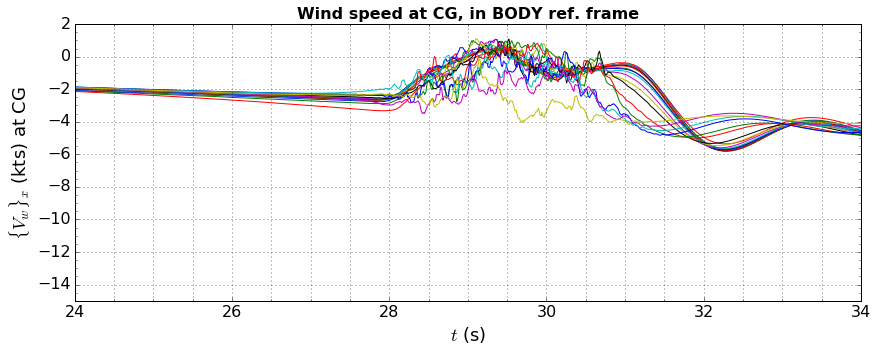

In [34]:
Gr50.plot_results('Vw_x_kts', ax_lim =[t1_50, t2_50, -15, 2])
Gr100.plot_results('Vw_x_kts', ax_lim =[t1_100, t2_100, -15, 2])

Total time required: 13.23 s
Total time required: 12.49 s


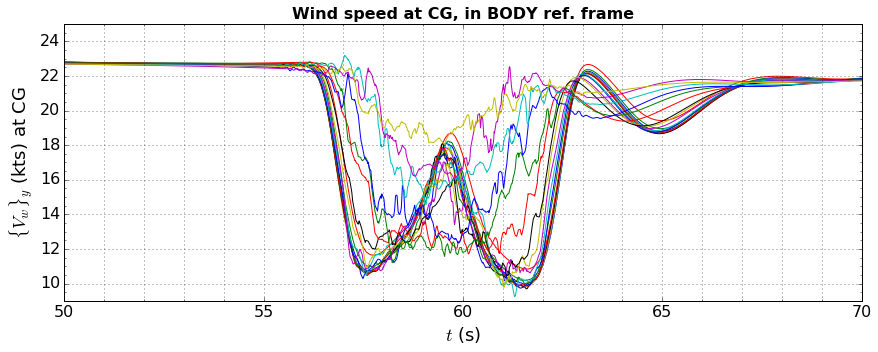

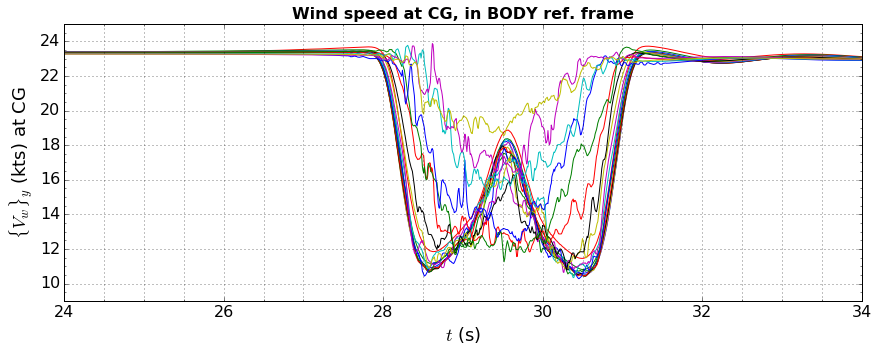

In [35]:
Gr50.plot_results('Vw_y_kts', ax_lim =[t1_50, t2_50, 9, 25])
Gr100.plot_results('Vw_y_kts', ax_lim =[t1_100, t2_100, 9, 25])

Total time required: 12.23 s
Total time required: 11.17 s


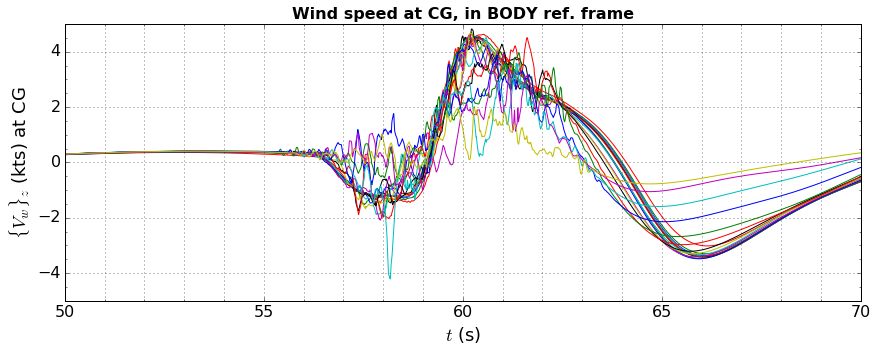

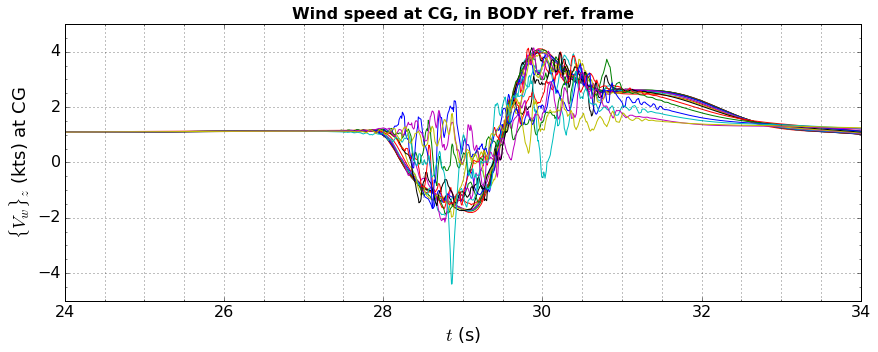

In [36]:
Gr50.plot_results('Vw_z_kts', ax_lim =[t1_50, t2_50, -5, 5])
Gr100.plot_results('Vw_z_kts', ax_lim =[t1_100, t2_100, -5, 5])

## Load factors

Total time required: 11.84 s
Total time required: 11.38 s


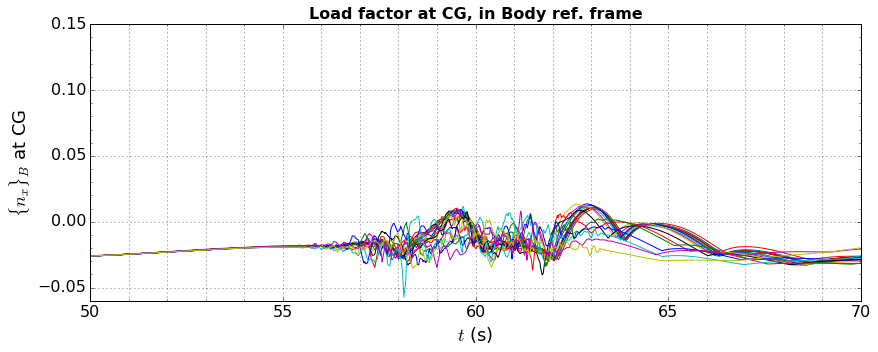

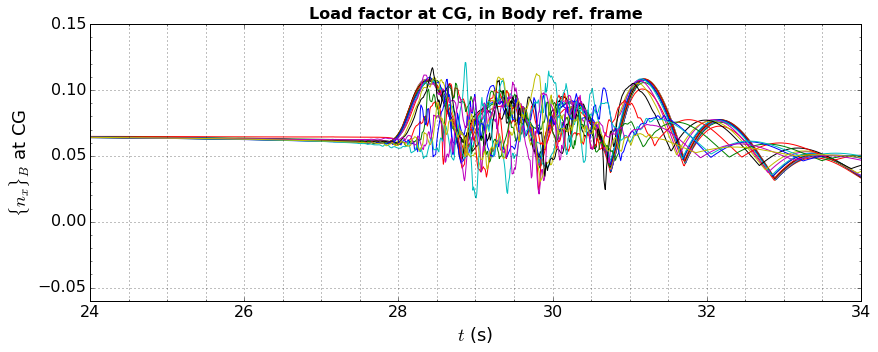

In [50]:
Gr50.plot_results('n_x', ax_lim =[t1_50, t2_50, -0.06,0.15])
Gr100.plot_results('n_x', ax_lim =[t1_100, t2_100, -0.06,0.15])

Total time required: 14.24 s
Total time required: 12.79 s


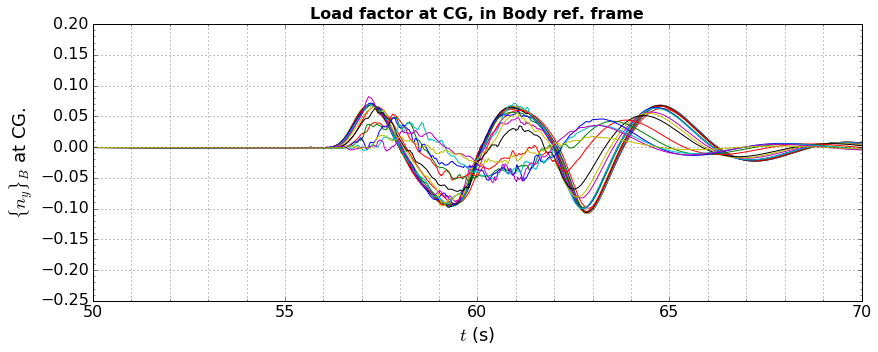

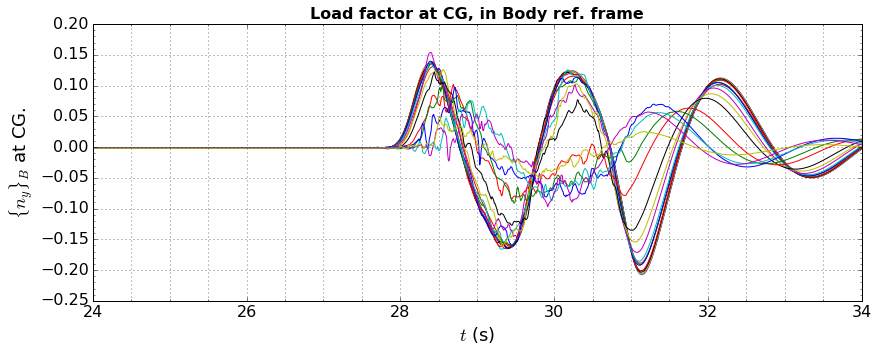

In [52]:
Gr50.plot_results('n_y', ax_lim =[t1_50, t2_50,  -0.25,0.2])
Gr100.plot_results('n_y', ax_lim =[t1_100, t2_100,  -0.25,0.2])

Total time required: 11.24 s
Total time required: 10.38 s


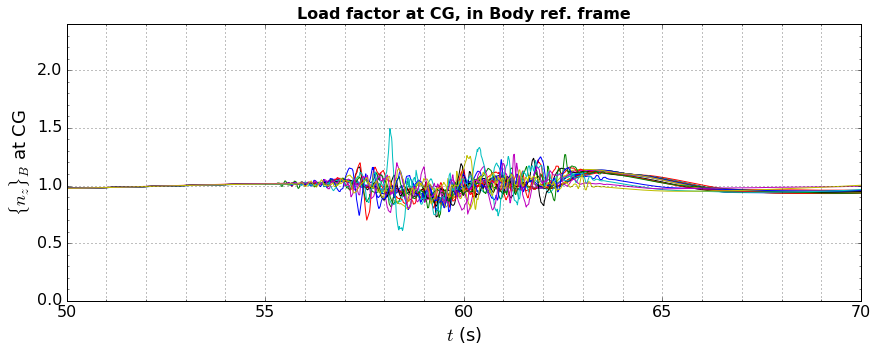

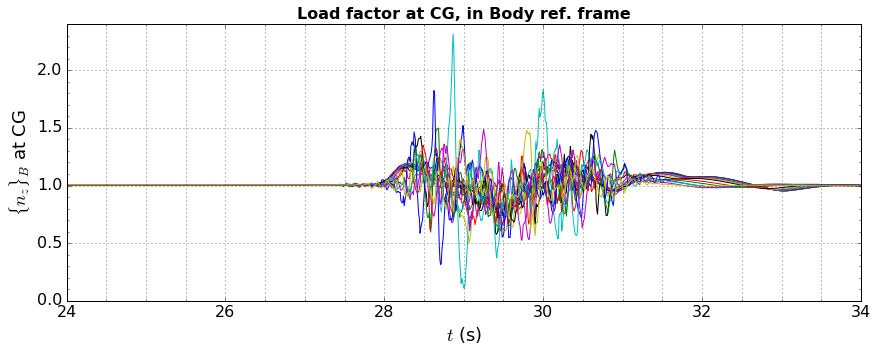

In [60]:
Gr50.plot_results('n_z', ax_lim =[t1_50, t2_50, 0.0, 2.4])
Gr100.plot_results('n_z', ax_lim =[t1_100, t2_100, 0.0, 2.4])

## A closer look based on distance from the turbine
### The five closest trajectories

Total time required: 2.81 s
Total time required: 3.36 s


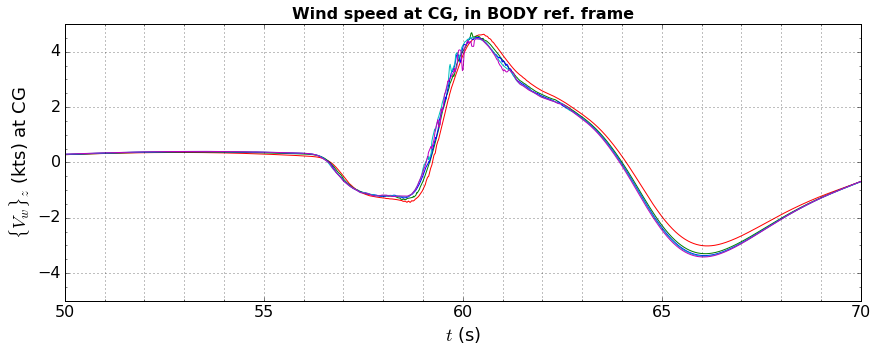

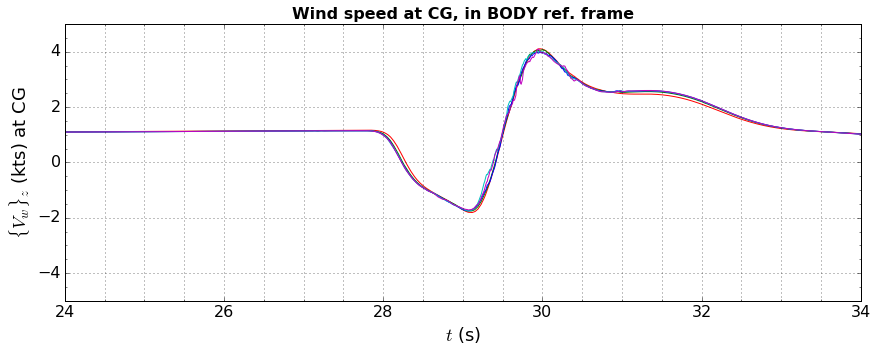

In [53]:
Gr50A.plot_results('Vw_z_kts', ax_lim =[t1_50, t2_50, -5, 5])
Gr100A.plot_results('Vw_z_kts', ax_lim =[t1_100, t2_100, -5, 5])

Total time required: 2.81 s
Total time required: 2.81 s


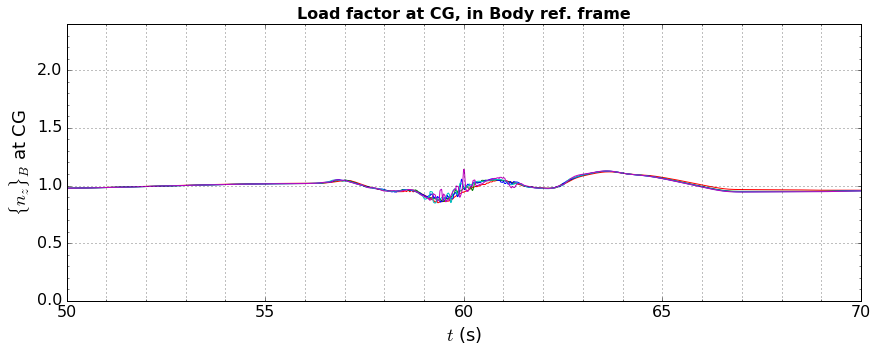

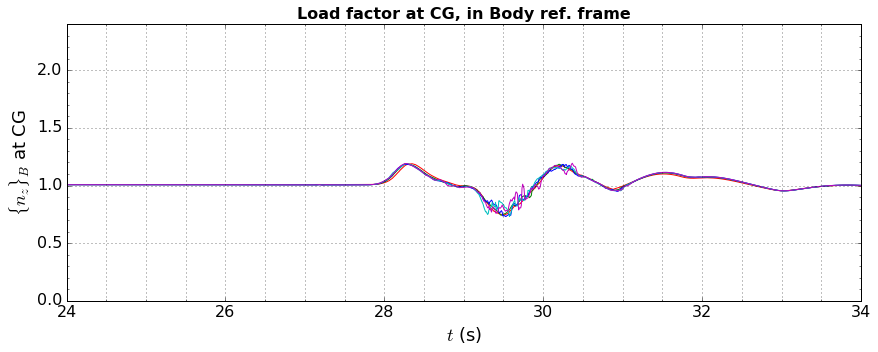

In [59]:
Gr50A.plot_results('n_z', ax_lim =[t1_50, t2_50, 0.0, 2.4])
Gr100A.plot_results('n_z', ax_lim =[t1_100, t2_100, 0.0, 2.4])

### The five farthest trajectories

Total time required: 2.75 s
Total time required: 2.69 s


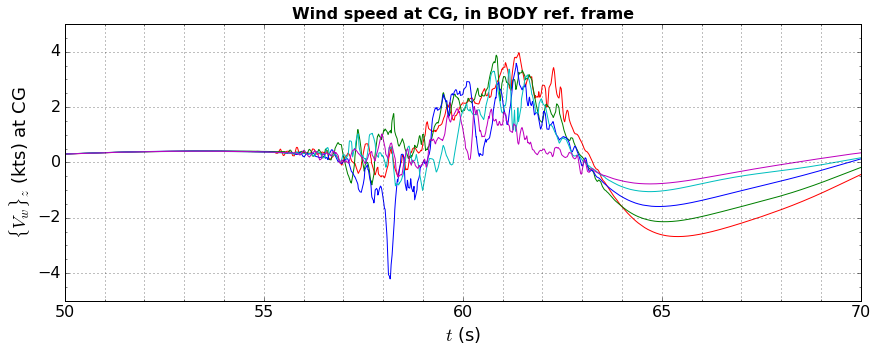

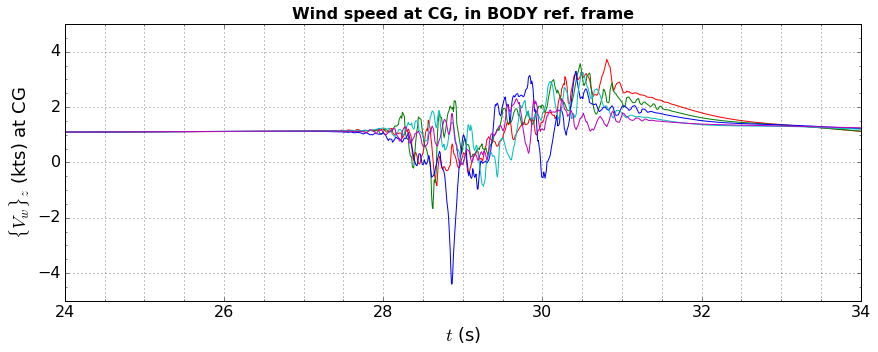

In [56]:
Gr50B.plot_results('Vw_z_kts', ax_lim =[t1_50, t2_50, -5, 5])
Gr100B.plot_results('Vw_z_kts', ax_lim =[t1_100, t2_100, -5, 5])

Total time required: 2.82 s
Total time required: 2.76 s


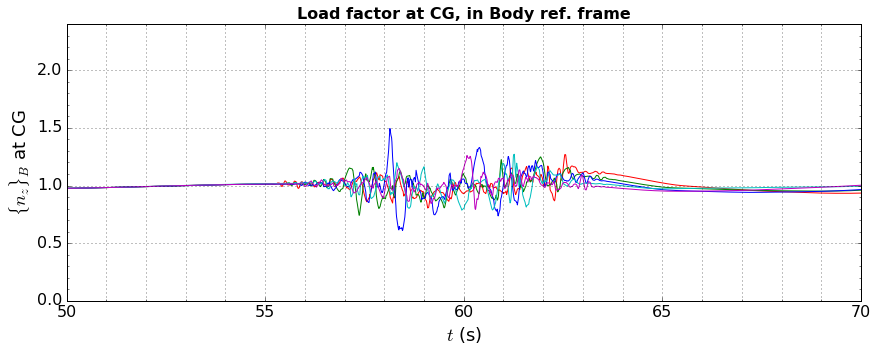

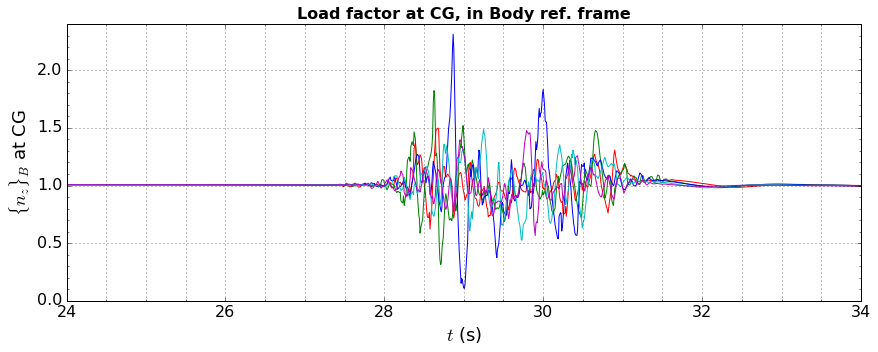

In [58]:
Gr50B.plot_results('n_z', ax_lim =[t1_50, t2_50, 0.0, 2.4])
Gr100B.plot_results('n_z', ax_lim =[t1_100, t2_100, 0.0, 2.4])

## Extracting final results

Index     Altit.    dist/D    nz_max    nz_min    nz_avg    nz_std    Ww_max    Ww_min    Ww_avg    Ww_std
---------------------------------------------------------------------------------------------------------------
0001     90.23      1.00      1.12      0.85      1.00      0.05      4.63     -3.02      0.03      1.85
0002     89.49      2.00      1.12      0.86      1.00      0.05      4.69     -3.30     -0.02      1.89
0003     89.33      2.99      1.12      0.86      1.00      0.05      4.52     -3.37     -0.03      1.90
0004     89.23      3.99      1.12      0.85      1.00      0.05      4.52     -3.39     -0.02      1.91
0005     89.21      4.99      1.14      0.86      1.00      0.05      4.48     -3.42     -0.04      1.90
0006     89.22      5.99      1.13      0.81      1.00      0.05      4.47     -3.42     -0.05      1.89
0007     89.20      6.99      1.12      0.73      1.00      0.05      4.83     -3.41     -0.04      1.90
0008     89.31      7.99      1.14      0.81  

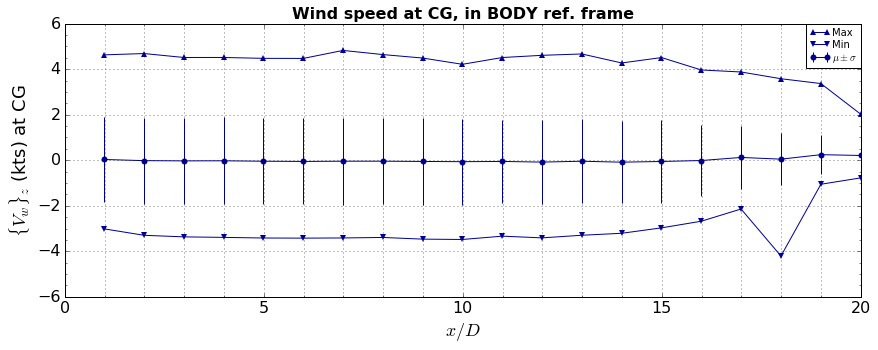

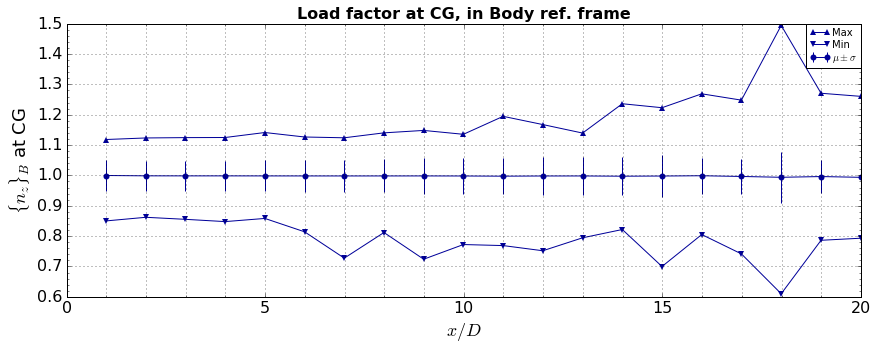

In [47]:
Gr50.results(XY_turb=[X_t, Y_t], D_turb=D_t, windDir=270, t_lim=[t1_50, t2_50], linestyle='-')

Index     Altit.    dist/D    nz_max    nz_min    nz_avg    nz_std    Ww_max    Ww_min    Ww_avg    Ww_std
---------------------------------------------------------------------------------------------------------------
0001     90.06      1.00      1.19      0.74      1.01      0.07      4.11     -1.81      1.32      1.19
0002     89.90      2.00      1.19      0.74      1.02      0.07      4.07     -1.76      1.32      1.20
0003     89.81      3.00      1.18      0.73      1.02      0.07      4.00     -1.75      1.32      1.20
0004     89.75      4.00      1.19      0.73      1.02      0.07      4.01     -1.75      1.33      1.19
0005     89.72      5.00      1.19      0.76      1.02      0.07      4.10     -1.72      1.32      1.18
0006     89.72      6.00      1.22      0.60      1.02      0.07      3.99     -1.70      1.31      1.19
0007     89.67      7.00      1.22      0.58      1.02      0.08      4.15     -1.74      1.33      1.18
0008     89.64      8.00      1.27      0.61  

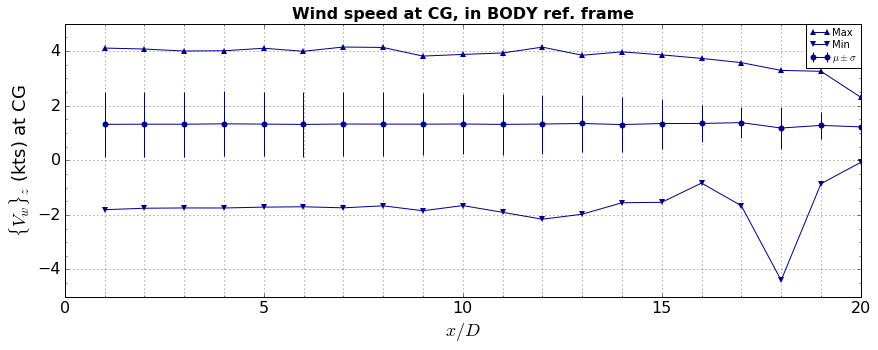

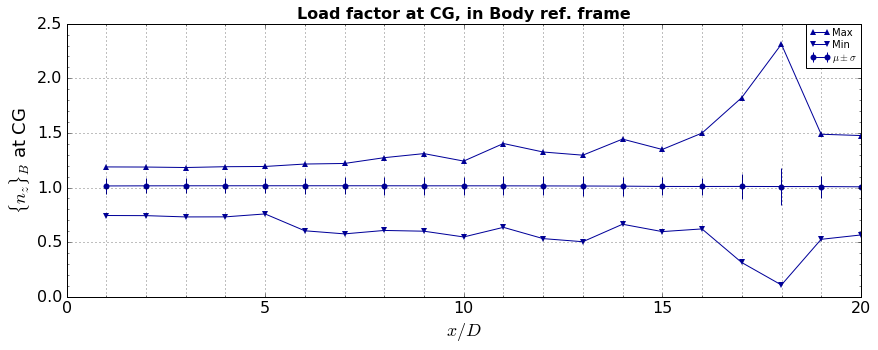

In [48]:
Gr100.results(XY_turb=[X_t, Y_t], D_turb=D_t, windDir=270, t_lim=[t1_100, t2_100], linestyle='-')